In [91]:
import numpy as np
import cv2, os
import matplotlib.pyplot as plt
from math import cos, atan, radians, degrees, tan, sin

In [92]:
fp_root = r'D:\Downloads\check'
fp_img_before = os.path.join(fp_root, 'before', '0.jpg')
fp_img_after = os.path.join(fp_root, 'after', '0.jpg')
fp_img_points_before = fp_img_before.replace('0.jpg', 'img_points.txt')
fp_object_points_before = fp_img_before.replace('0.jpg', 'object_points.txt')
fp_img_points_after = fp_img_points_before.replace('before', 'after')
fp_object_points_after = fp_object_points_before.replace('before', 'after')
fp_ins = os.path.join(fp_root, 'calibrate', 'intrinsic.txt')
fp_dis = os.path.join(fp_root, 'calibrate', 'distcoef.txt')

img_before = cv2.imread(fp_img_before)
img_after = cv2.imread(fp_img_after)
intrinsic = np.loadtxt(fp_ins)
distcoefs = np.loadtxt(fp_dis)
img_points_before = np.loadtxt(fp_img_points_before)
img_points_after = np.loadtxt(fp_img_points_after)
object_points_before = np.loadtxt(fp_object_points_before)
object_points_after = np.loadtxt(fp_object_points_after)

object_points_before = np.array([x.tolist() + [0.0] for x in object_points_before])
object_points_after = np.array([x.tolist() + [0.0] for x in object_points_after])

alpha, delta_h, h = 43.4, 300, 1005

In [93]:
_, rvec, tvec = cv2.solvePnP(object_points_before, img_points_before, intrinsic, distcoefs)
rmat = cv2.Rodrigues(rvec)[0]

zcs = []
for i in range(object_points_before.shape[0]):
    zcs.append((intrinsic @ (rmat @ object_points_before[i, :].reshape((-1, 1)) + tvec))[2, 0])

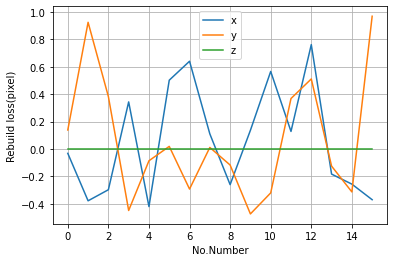

In [94]:
loss = []
img_points_before_cal = np.array([x.tolist() + [1.0] for x in img_points_before])
for i in range(img_points_before.shape[0]):
    loss.append(intrinsic @ (rmat @ object_points_before[i, :].reshape((-1, 1)) + tvec) / zcs[i] -
                img_points_before_cal[i, :].reshape((-1, 1)))
loss = np.squeeze(np.array(loss))
plt.figure()
for i in range(loss.shape[1]):
    plt.plot(loss[:, i])
plt.legend(['x', 'y', 'z'])
plt.xlabel('No.Number')
plt.ylabel('Rebuild loss(pixel)')
plt.grid(True)
plt.show()

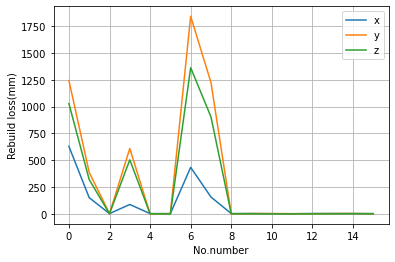

In [95]:
img_points_after_cal = np.array([x.tolist() + [1.0] for x in img_points_after])
loss = []
for i in range(len(zcs)):
    # 两种情况下进行水面升高后的zcs计算，计算公式参考PDF
    if zcs[i] > h / cos(radians(alpha)):
        beta = degrees(atan(((zcs[i] - h / cos(radians(alpha)))
                             / sin(radians(alpha)) + h * tan(radians(alpha))) / (h - delta_h))) - alpha
        zc = ((zcs[i] - h / cos(radians(alpha))) / sin(radians(alpha)) + h * tan(radians(alpha))) \
              / sin(radians(alpha + beta)) * cos(radians(beta))
    else:
        beta = degrees(atan((h * tan(radians(alpha)) - (h / cos(radians(alpha)) - zcs[i])
                             / sin(radians(alpha))) / (h - delta_h)))
        zc = (h - delta_h) / cos(radians(beta)) * cos(radians(alpha - beta))
    object_points_cal = np.linalg.inv(rmat) @ (zc * np.linalg.inv(intrinsic) @
                                                     img_points_after_cal[i, :].reshape((-1, 1)) - tvec)
    object_points_cal[2, 0] -= delta_h
    loss.append(np.abs(object_points_cal - object_points_after[i, :].reshape((-1, 1))))
loss = np.squeeze(np.array(loss))
plt.figure()
for i in range(loss.shape[1]):
    plt.plot(loss[:, i])
plt.legend(['x', 'y', 'z'])
plt.xlabel('No.number')
plt.ylabel('Rebuild loss(mm)')
plt.grid(True)
plt.show()